# Coordinates in the SunPy Ecosystem

In [20]:
import glob

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.time

from sunpy.net import Fido, attrs as a
from sunpy.coordinates import Helioprojective, get_earth
import sunpy.map
import sunpy.timeseries

## Extending `astropy.coordinates`

## Applications

### Plotting Flare Position

In addition to providing an interface to search for data files that can be downloaded, Fido also allows you to query metadata.
Currently Fido supports metadata searching from several different data sources.
Lets look at an example of how we can use Fido to query the Heliophysics Event Knowledgebase (HEK).

Lets query the HEK for flares that occurred around the time of our CME.
This can be done by using the HEK client specific attributes `a.hek.attrs`.

In [9]:
cme_start = astropy.time.Time("2022-02-15 21:45")
cme_end = astropy.time.Time("2022-02-16 00:30")

In [10]:
hek_query = a.Time(cme_start-6*u.h, cme_end) & a.hek.EventType('FL')

In [11]:
hek_result = Fido.search(hek_query)

The HEK keeps track of a lot of information for each event in the database.
Let's filter this down to the start, end, and peak times of the flare, the GOES classification, and the coordinates of the flare on the disk.

In [13]:
flare_table = hek_result['hek'][
    'event_starttime',
    'event_peaktime',
    'event_endtime',
    'fl_goescls',
    'hpc_x',
    'hpc_y',
]

In [14]:
flare_table

event_starttime,event_peaktime,event_endtime,fl_goescls,hpc_x,hpc_y
Time,Time,Time,str4,float64,float64
2022-02-15 17:22:12.000,2022-02-15 18:32:24.000,2022-02-15 20:10:00.000,,871.14954,478.49194
2022-02-15 17:24:00.000,2022-02-15 17:39:00.000,2022-02-15 17:54:00.000,B9.5,877.7694,385.545282
2022-02-15 17:54:00.000,2022-02-15 18:15:00.000,2022-02-15 18:31:00.000,M1.3,862.2147,439.024398
2022-02-15 18:01:08.000,2022-02-15 18:16:56.000,2022-02-15 18:47:32.000,,883.2,422.4
2022-02-15 18:03:34.000,2022-02-15 18:04:34.000,2022-02-15 18:05:34.000,,883.2,422.4
2022-02-15 20:33:32.000,2022-02-15 20:34:56.000,2022-02-15 20:39:44.000,,883.2,422.4
2022-02-15 23:05:00.000,2022-02-15 23:13:00.000,2022-02-15 23:20:00.000,B7.1,864.18786,427.647576
2022-02-15 23:20:00.000,2022-02-15 23:26:00.000,2022-02-15 23:30:00.000,B6.8,579.767628,-229.419378
2022-02-15 23:41:00.000,2022-02-15 23:46:00.000,2022-02-15 23:52:00.000,B8.6,857.91882,431.300778


Additionally, let's load back in our timeseries over the entire time interval of interest.

In [18]:
goes_files = sorted(glob.glob('data/XRS/*.nc'))
ts1,ts2 = sunpy.timeseries.TimeSeries(goes_files)
ts_combined = ts1.concatenate(ts2)

First, let's plot the times of the flares on top of our untruncated timeseries.
We'll indicate each flare with a shaded blue region and our original time interval of interest that we used to query our imaging observations with an orange colorbar.

(19038.708333333332, 19039.020833333332)

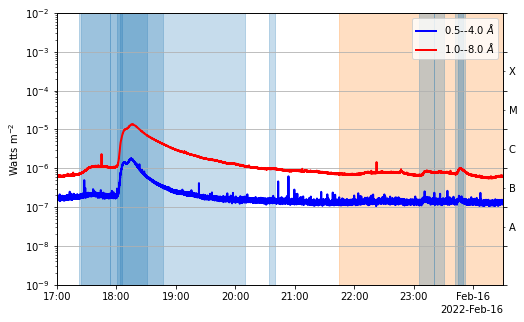

In [22]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ts_combined.plot(axes=ax)
y = np.linspace(1e-9, 1e-2, 10)
ax.fill_betweenx(y, "2022-02-15 21:45", "2022-02-16 00:30", alpha=0.25, color='C1')
for fl in flare_table:
    ax.fill_betweenx(y, fl['event_starttime'].iso, fl['event_endtime'].iso,
                     edgecolor='C0', facecolor='C0', alpha=0.25)
ax.set_xlim("2022-02-15 17:00", "2022-02-16 00:30")

We see from the plot and manually examining the table above that only a few flares occurred within our window of interest and that most occurred many hours before, around 17:00 on 2/15.

To further understand whether these flares in the HEK database correspond to the observed CME, we can plot the positions of the flares on our AIA image.

We'll do this by first constructing a `SkyCoord` to denote the position of each flare.

In [23]:
flare_coords = []
for fl in flare_table:
    earth = get_earth(fl['event_starttime'])
    hpc_frame = Helioprojective(obstime=fl['event_peaktime'], observer=earth)
    hpc_coord = SkyCoord(Tx=fl['hpc_x']*u.arcsec, Ty=fl['hpc_y']*u.arcsec, frame=hpc_frame)
    flare_coords.append(hpc_coord)

Let's load back in our AIA 304 image and overplot this coordinates on the solar disk.

In [24]:
m_aia = sunpy.map.Map('data/AIA/aia_lev1_304a_2022_02_15t22_15_05_13z_image_lev1.fits')

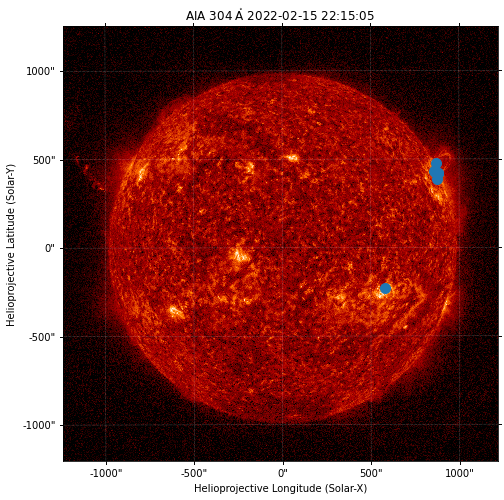

In [25]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=m_aia)
m_aia.plot(axes=ax, vmin=0, vmax=2e2)
for fl in flare_coords:
    with Helioprojective.assume_spherical_screen(m_aia.observer_coordinate):
        ax.plot_coord(fl, marker='o', color='C0', markersize=10)

(It is probably not enough to just transform to the coordinate frame given the difference in observer times...should we be applying some sort of differential rotation as well?)

(Explanation of `plot_coord` and `assume_spherical_screen`)

Looking at the plot of our flare locations on the disk, we find that the flares are clustered nearly all along the west limb, while our CME launched from the east limb.
Thus, we find that none of the flares detected by GOES correspond to the observed CME.
From our EUI and STEREO imagery, we can see that the CME was directed away from earth on the backside of the Sun (relative to Earth).
Thus, the associated flare emission was not in the line of sight of the GOES spacecraft which is in a geostationary orbit.